In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from os import makedirs, listdir
from os.path import join, isfile, isdir, exists, splitext
from pprint import pprint
import json
Settings = json.load(open('settings.txt'))
pprint(Settings)
print("")
from pak.datasets.MOT import MOT16
from pak import utils
import sys
sys.path.append('../')

from cabbage.features.deepmatching import DeepMatching
import cabbage.features.spatio as st
from cabbage.features.ReId import StackNet64x64, get_element

# -------------------------

root = Settings['data_root']
mot16 = MOT16(root)

stacknet = StackNet64x64(root)

delta_max = 3
dm = DeepMatching(Settings['deepmatch'], join(root, 'deep_matching'),
                 delta_max=delta_max)

VIDEO = "MOT16-02"
img_loc = mot16.get_test_imgfolder(VIDEO)

X, Y_det, Y_gt = mot16.get_train(VIDEO, memmapped=True)

{'data_root': '/home/data',
 'deepmatch': '/home/deepmatching_1.2.2_c++/deepmatching-static'}



Using TensorFlow backend.


/home/data/MOT16 found :)
Found model /home/data/reid_models/stacknet64x64_84acc.h5! :)
MOT16: load memmapped file /home/data/MOT16/train/MOT16-02/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded


## Generate Deep Matches

For performance reasons we need to pre-generate the deep matches using the API functions

In [2]:
#dm.generate_matches(img_loc, VIDEO)

## Get a Match

In [3]:
M = dm.get_match(VIDEO, frame1=1, frame2=2)
print(M.shape)

(1980, 6)


In [4]:
#y = predict_stacknet64x64()

reid cost (red vs red):	 [[ 0.96538562  0.03461444]]
reid cost (red vs blue):  [[ 0.96560526  0.03439475]]
dm cost (red vs red):	 1.0
dm cost (red vs blue):	 1e-10
st cost (red vs red):	 1e-10
st cost (red vs blue):	 1.77991192197


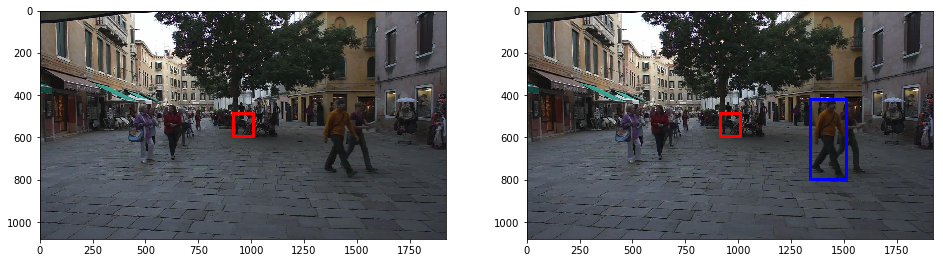

In [5]:
frame1, _, x, y, w, h, _, _, _ = Y_gt[0]


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.imshow(X[0])
bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
ax.plot(bbX, bbY, linewidth=3, c='red')
bb1 = (x,y,w,h)
Im1 = get_element(X[int(frame1)-1], bb1, (64,64))

frame2, _, x, y, w, h, _, _, _ = Y_gt[2]
ax = fig.add_subplot(122)
ax.imshow(X[int(frame2)-1])
bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
ax.plot(bbX, bbY, linewidth=3, c='red')
bb2 = (x,y,w,h)
Im2 = get_element(X[1], bb2, (64,64))

frame3, _, x, y, w, h, _, _, _ = Y_gt[601]
bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
ax.plot(bbX, bbY, linewidth=3, c='blue')
bb3 = (x,y,w,h)
Im3 = get_element(X[int(frame3)-1], bb3, (64,64))
# ----------------------

cost_red_red = stacknet.predict(Im1, Im2)
cost_red_blue = stacknet.predict(Im1, Im3)

print("reid cost (red vs red):\t", cost_red_red)
print("reid cost (red vs blue): ", cost_red_blue)

cost1 = dm.calculate_cost(VIDEO, frame1, bb1, frame2, bb2)
cost2 = dm.calculate_cost(VIDEO, frame1, bb1, frame3, bb3)
print("dm cost (red vs red):\t", cost1)
print("dm cost (red vs blue):\t", cost2)

cost1 = st.calculate(bb1, bb2)
cost2 = st.calculate(bb1, bb3)
print("st cost (red vs red):\t", cost1)
print("st cost (red vs blue):\t", cost2)

plt.show()